In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import patsy
import seaborn as sns

In [2]:
# the following function is copied from https://github.com/Teichlab/NaiveDE/blob/master/NaiveDE/base.py
# it is a python implementation of limma's removeBatchEffect function
# many thanks to Valentine Svensson (https://github.com/vals)

def regress_out(sample_info, expression_matrix, covariate_formula, design_formula='1', rcond=-1):
    # Ensure intercept is not part of covariates
    covariate_formula += ' - 1'

    covariate_matrix = patsy.dmatrix(covariate_formula, sample_info)
    design_matrix = patsy.dmatrix(design_formula, sample_info)

    design_batch = np.hstack((design_matrix, covariate_matrix))

    coefficients, res, rank, s = np.linalg.lstsq(design_batch, expression_matrix.T, rcond=rcond)
    beta = coefficients[design_matrix.shape[1]:]
    regressed = expression_matrix - covariate_matrix.dot(beta).T

    return regressed

In [3]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

sns.set_style('ticks')
sns.set_palette("Set1")

# Read human EPSCs data

In [4]:
epsc_count = pd.read_csv('epsc_count.csv', index_col=0)
epsc_info = pd.read_csv('epsc_info.csv', index_col=0)

# Read huamn embryo data from Yan et al

In [5]:
yan_count = pd.read_csv('yan_count.csv', index_col=0)
yan_info = pd.read_csv('yan_info.csv', index_col=0)

# Merge and compare

In [6]:
comp_info = pd.concat([epsc_info, yan_info], join="inner")
comp_count = pd.concat([epsc_count, yan_count], axis=1, join="inner")

In [7]:
log_count = np.log10(comp_count + 1)

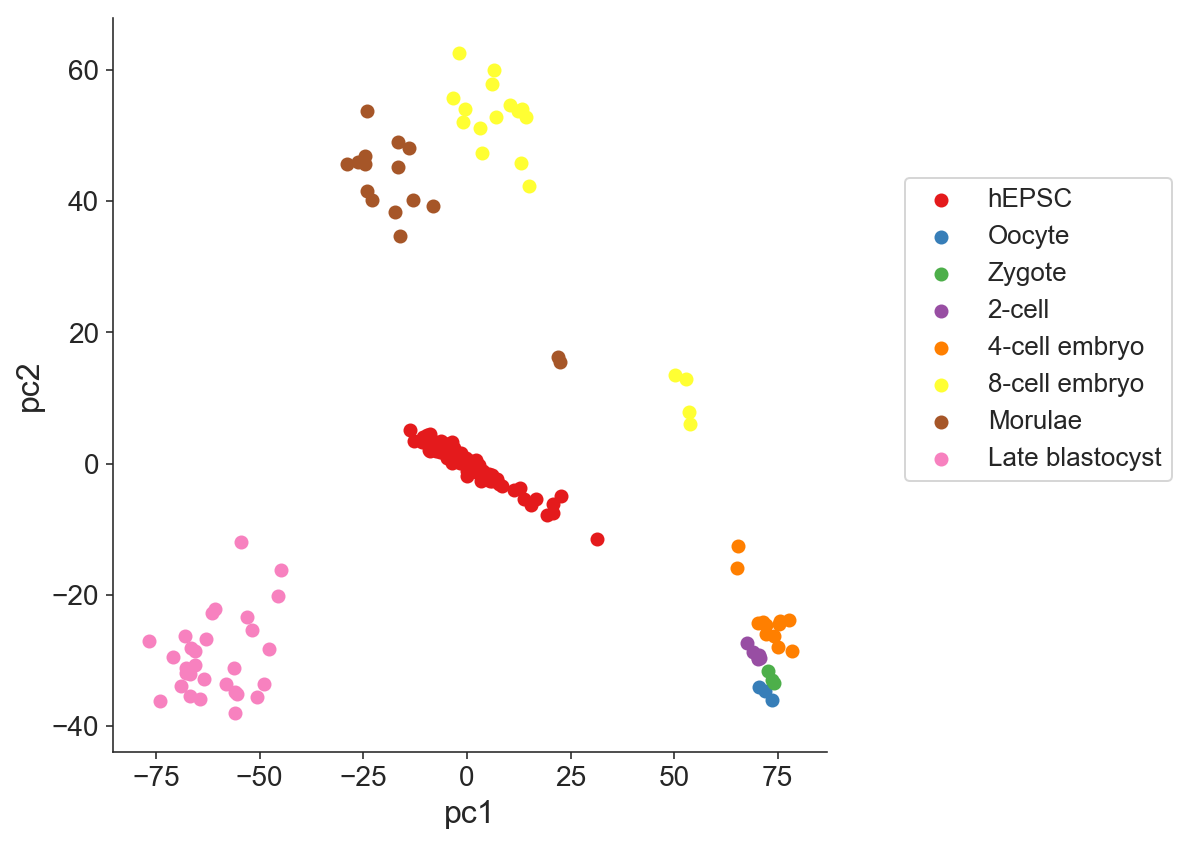

In [8]:
comp_reg = regress_out(comp_info, log_count, "~np.log10(total_count) + study_reference", rcond=1e-4)

pca = PCA(2)
Y_n = pca.fit_transform(scale(comp_reg.T, 1, with_std=False))
comp_info['pc1'] = Y_n[:, 0]
comp_info['pc2'] = Y_n[:, 1]

g = sns.FacetGrid(comp_info, hue="cells", height=6)
g.map(plt.scatter, "pc1", "pc2")

g.ax.legend(bbox_to_anchor=[1.5, 0.8])
#plt.savefig('pca_hepsc_vs_yan_et_al.pdf', bbox_inches='tight', trasparent=True)